# There's No Such Thing as a Free Lunch

In the field of machine learning, the "no free lunch" theorem "state[s] that any two optimization 
algorithms are equivalent when their performance is averaged across all possible problems" (see [1] 
and [2] for some references). That is, we can't tell which machine learning algorithm will best solve the problem in front of us. Of course, with more experience we'll be able to "intuit" which ones are better 
suited than others, but a priori we can't say which is the best one.

So we then need a way to measure if machine learning algorithm (A) is better than machine learning 
algorithm (B). Or for that matter, if (A) with parameters {l,m,n} or (A) with parameters {p,q,r} will do better. This 
is where **cross-validation** comes in.

[1] Wolpert, David (1996), "The Lack of A Priori Distinctions between Learning Algorithms", Neural Computation, pp. 1341-1390

[2] Wolpert, D.H., and Macready, W.G. (2005) "Coevolutionary free lunches", IEEE Transactions on Evolutionary Computation, 9(6): 721-735

# Cross-Validation

Cross-validation is a way to measure how well a machine learning algorithm will generalize to more data. It's a way to simulate going out and collecting more data, without the headache of actually collecting more data. And it is meant to prevent the embarassing (and potentially expensive!) moment when you realize the model you trained is not actually a good fit for your big dataset.

For prediction problems, the steps typically go like this:
1. Prepare a set of data where the **target** (the value we want to predict) is already known. 
2. Split this set into a **training set** and a **validation (or test) set**
3. Fit a model to the **training set**, and use the fit to predict values for the **validation set**
4. See how well the model predicts the **validation set**

A typical measure of model goodness is the **coefficient of determination, $R^2$**, which is defined as below:



## $R^{2}(y, \hat{y}) = 1 - \frac{\Sigma_{i=1}^{n_{samples}} (y_{i} - \hat{y}_{i})^{2}}{\Sigma_{i=1}^{n_{samples}}(y_{i}-\bar{y})^{2}}$

- $\hat{y}_{i}$ is the predicted value of $i$-th sample

- $y_{i}$ is the true value of $i$-th sample

- ### $\bar{y} = \frac{1}{n_{samples}} \Sigma_{i=1}^{n_{samples}} y_{i}$

The examples below go through picking a good training set, demonstrating the need for cross validation, and showing
a techniquie called k-fold cross validation that is especially important when there is not a lot of data.

# Picking a Training Set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn as skl
import numpy as np

import scripts.load_data as load

import seaborn as sns

%matplotlib inline

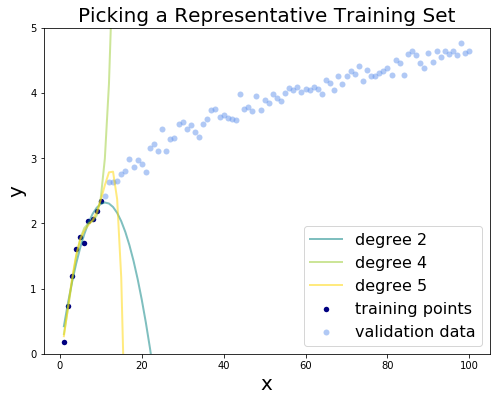

In [2]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

#set the seed so we get the same data each time we run the cell
np.random.seed(0)

#define a model to generate fake data
def data_model(x, sigma=0.1):
    base_model = np.log(x)
    noise = sigma * np.random.randn(len(x))
    return base_model + noise

#Generate some fake data and keep a subset of them
#for training
#***Try different values for N***
N_split = 10
x_plot = np.linspace(1,100,100)
x_train = x_plot[:N_split]
y_train = data_model(x_train)

#also make validation data
x_val = x_plot[N_split:]
y_val = data_model(x_val)
# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_val = x_val[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold', 'red']
lw = 0
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, color='navy', s=30, marker='o', label="training points", linewidth=lw)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.title('Picking a Representative Training Set',  fontsize=20)
plt.scatter(x_val, y_val, marker='o', color='cornflowerblue', alpha=0.5,linewidth=lw, label="validation data")

plt.ylim([0,5])
lw =2
for count, degree in enumerate([2, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    #fit to training data
    model.fit(X_train, y_train)
    #apply to validation data
    y_predicted = model.predict(X_val)
    #apply again, just to show plot
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, alpha=0.5,
             label="degree %d" %(degree))

plt.legend(loc='lower right', fontsize=16)


# Don't Evaluate The "Goodness" of a Model on Training Data Only

The example above is meant to illustrate two things:
1. Training on too little data yields poor results. (Typically people use 80% train, 20% validate)
2. Even if the split is sufficient, the training set must be devised to be representative of the data. Picking a bad training set will bias the model.

The example below shows the importance of evaluating our model on a reserved validation set, i.e the importance of
cross validation. Even if we have a "good" training set, calculating $R^{2}$ for the training set is not sufficient (reffered to as 'naive score' below). We must fit the training data, and calculate $R^{2}$ on a test set (also sometimes called a "hold-out" set). 

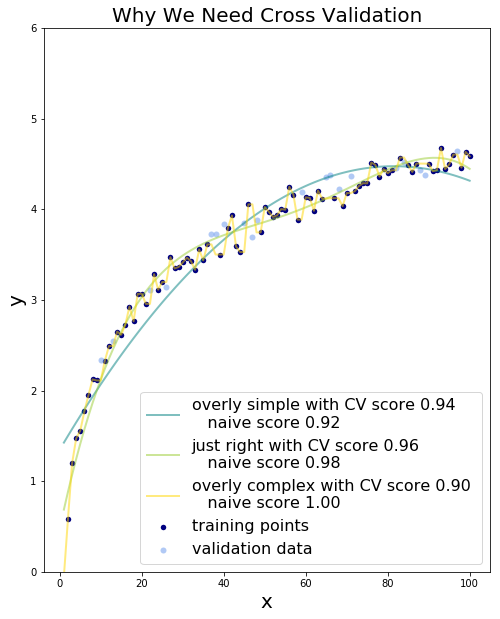

In [3]:
#this the same code as above
#except see how x_train is chosen differently

#set the seed you get the same data each time you run
np.random.seed(0)

#define a model to generate fake data
def data_model(x, sigma=0.1):
    base_model = np.log(x)
    noise = sigma * np.random.randn(len(x))
    return base_model + noise

#Generate some fake data and keep a subset of them
#for training
#***Try different values for N***
N_split = 80
x_plot = np.linspace(1,100,num=100)
x = np.copy(x_plot)

rng = np.random.RandomState(0)
rng.shuffle(x)
x_train = x[:N_split]
y_train = data_model(x_train)

#also make validation data
x_val = x[N_split:]
y_val = data_model(x_val)
# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_val = x_val[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold', 'red']
lw = 0
plt.figure(figsize = (8,10))
plt.scatter(x_train, y_train, color='navy', s=30, marker='o', label="training points", linewidth=lw)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.title('Why We Need Cross Validation', fontsize=20)
plt.scatter(x_val, y_val, marker='o', color='cornflowerblue', alpha=0.5,linewidth=lw, label="validation data")

plt.ylim([0,6])
lw =2

models = [
    make_pipeline(PolynomialFeatures(2), Ridge()), # Overly Simple
    make_pipeline(PolynomialFeatures(4), Ridge()), # Just Right
    DecisionTreeRegressor(max_depth=80)  # Overly Complex
]

labels = ['overly simple', 'just right', 'overly complex']
#for count, degree in enumerate([2, 5, 12]):
for count, model in enumerate(models):
    #fit to training data
    model.fit(X_train, y_train)
    y_train_fit = model.predict(X_train)
    nscore = skl.metrics.r2_score(y_train, y_train_fit)
    #apply to validation data
    y_predicted = model.predict(X_val)
    #get R^2 score
    score = skl.metrics.r2_score(y_val, y_predicted)
    #apply again, just to show plot
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, alpha=0.5,
             label=labels[count] + " with CV score %0.02f \n   naive score %0.02f" %(score, nscore))

plt.legend(loc='lower right', fontsize=16);




The example above shows why we need a good training set and a validation set to cross validate the model. 
If we only looked at the 'naive score', we would think the best fit is the overly-complex model because 
it has a "perfect score" of 1.0. But the relatively low cross validation score (0.90) of the overly-complex model
indicates it doesn't generalize to new data, so it's not the best choice.

The next section gives more examples and introdues the concept of **k-fold cross validation**.


# Why K-Fold Cross Validation?

When we only have a few data points, we have to be even more careful. We can have a good, representative training set, a good train/validate split, a good CV score and _still_ pick the wrong model!

Leaving a specific point in the validation set biases the cross validation score because that single, 
specific data point is given too much importance / statistical weight. To avoid this, a method called
**k-fold cross validation** is employed. K-fold cross validation picks _k_ training and validation sets 
from the data, ensuring that each point takes a turn in a training set and validation set. The average
of the k-fold cross validation scores is taken to indicate which model is the best.

In the plots below, take note of the effect on CV score of having a specific data point in the validation set.

It should be noted that there are multiple methods that achieve the same results as k-fold cross 
validation. K-fold is one of the simplest to employ in scikit learn.

## Training Set 1


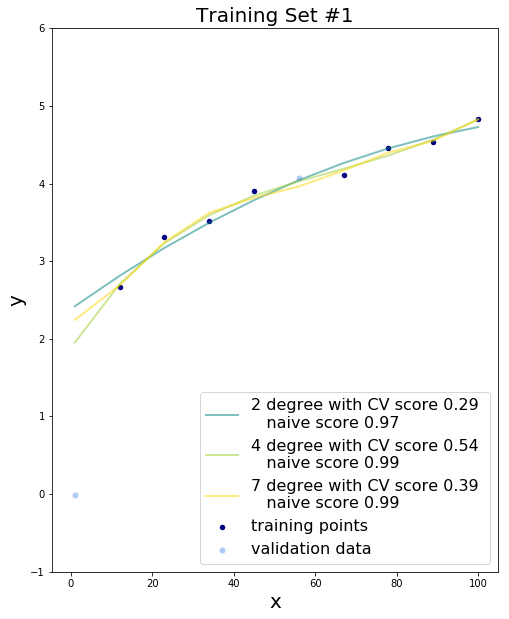

In [4]:
#this the same code as above

from sklearn.model_selection import cross_val_score

###**TRAINING SET 1 *** ###
#set the seed you get the same data each time you run
np.random.seed(0)

#define a model to generate fake data
def data_model(x, sigma=0.1):
    base_model = np.log(x)
    noise = sigma * np.random.randn(len(x))
    return base_model + noise

#Generate some fake data and keep a subset of them
#for training
#***Try different values for N***
N_split = 8
x_plot = np.linspace(1,100,num=10)
x = np.copy(x_plot)

rng = np.random.RandomState(0)
rng.shuffle(x)
x_train = x[:N_split]
y_train = data_model(x_train)

#also make validation data
x_val = np.sort(x[N_split:])
y_val = data_model(x_val)
# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_val = x_val[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold', 'red']

lw = 0
plt.figure(figsize = (8,10))
plt.scatter(x_train, y_train, color='navy', s=30, marker='o', label="training points", linewidth=lw)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(x_val, y_val, marker='o', color='cornflowerblue', alpha=0.5,linewidth=lw, label="validation data")

plt.ylim([-1,6])
lw =2

models = [
    make_pipeline(PolynomialFeatures(2), Ridge()),
    make_pipeline(PolynomialFeatures(4), Ridge()),
    make_pipeline(PolynomialFeatures(7), Ridge())  
]

labels = ['2 degree', '4 degree', '7 degree']
#for count, degree in enumerate([2, 5, 12]):
for count, model in enumerate(models):
    #fit to training data
    model.fit(X_train, y_train)
    y_train_fit = model.predict(X_train)
    nscore = skl.metrics.r2_score(y_train, y_train_fit)
    #apply to validation data
    y_predicted = model.predict(X_val)
    #get R^2 score
    score = skl.metrics.r2_score(y_val, y_predicted)
    #apply again, just to show plot
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, alpha=0.5,
             label=labels[count] + " with CV score %0.02f \n   naive score %0.02f" %(score, nscore))

plt.title('Training Set #1', fontsize=20)
plt.legend(loc='lower right', fontsize=16);


**Training Set 1** (above) suggests that the best choice is 4-degree becaus it has the best CV score. The 4-degree polynomial fits the training data well, but by the choice of validation set it _looks_ like it does not generalize very well when presented with a new data point down near (0,0). Let's see the effect of trying a different training set.

## Training Set 2


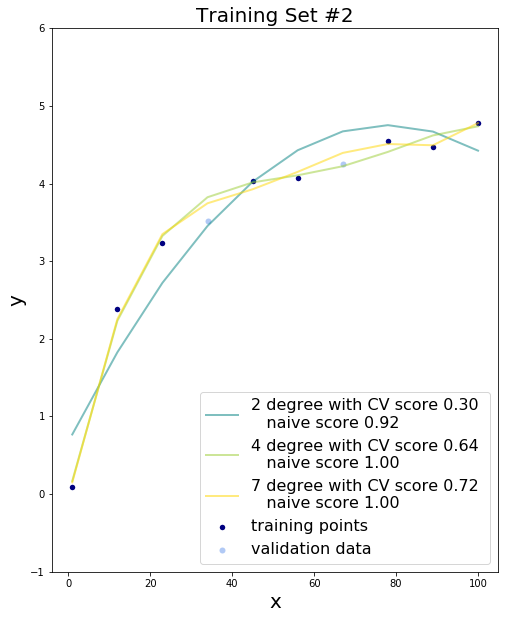

In [5]:
###**TRAINING SET 2 *** ###
###try another training & validation split
#set the seed you get the same data each time you run
np.random.seed(0)

x_plot = np.linspace(1,100,num=10)
x = np.copy(x_plot)

rng = np.random.RandomState(5)
rng.shuffle(x)
x_train = x[:N_split]
y_train = data_model(x_train)

#also make validation data
x_val = np.sort(x[N_split:])
y_val = data_model(x_val)
# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_val = x_val[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]


colors = ['teal', 'yellowgreen', 'gold', 'red']
lw = 0
plt.figure(figsize = (8,10))
plt.scatter(x_train, y_train, color='navy', s=30, marker='o', label="training points", linewidth=lw)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(x_val, y_val, marker='o', color='cornflowerblue', alpha=0.5,linewidth=lw, label="validation data")

plt.ylim([-1,6])
lw =2
models = [
    make_pipeline(PolynomialFeatures(2), Ridge()),
    make_pipeline(PolynomialFeatures(4), Ridge()),
    make_pipeline(PolynomialFeatures(7), Ridge())  
]

#for count, degree in enumerate([2, 5, 12]):
for count, model in enumerate(models):
    #fit to training data
    model.fit(X_train, y_train)
    y_train_fit = model.predict(X_train)
    nscore = skl.metrics.r2_score(y_train, y_train_fit)
    #apply to validation data
    y_predicted = model.predict(X_val)
    #get R^2 score
    score = skl.metrics.r2_score(y_val, y_predicted)
    #apply again, just to show plot
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, alpha=0.5,
             label=labels[count] + " with CV score %0.02f \n   naive score %0.02f" %(score, nscore))

plt.title('Training Set #2', fontsize=20)
plt.legend(loc='lower right', fontsize=16);



**Training Set 2** suggests that the best choice is 7-degree because it has the best CV score. However, its naive score is 1.0, which is a pretty good indication that it is probably over-fitting. Note that the 4-degree polynomial fit returned different model parameters this time, and it actually does fit the point near (0,0). 

These examples are meant to illustrate how a specific point being in the validation set or not can result in different CV scores for the same model. I.e the particular validation set is a source of bias. So which model is correct!?

The way we deal with this is by doing **k-fold cross validatoin** -- doing several cross validations and averaging the scores. This gives each point a 'turn' in the validation data, and averaging over the scores ensures that any single data point doesn't determine which model we ultimately choose. 


## K-Fold Cross Validation Example

The cell below shows how to use k-fold cross validation.


[-0.3125672655724972, 0.36535427184409019, -7.5615426879007588]


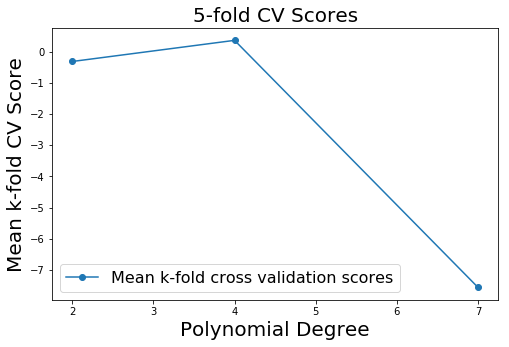

In [6]:
###Using k-fold cross validation

np.random.seed(0)
x_plot = np.linspace(1,100,num=10)
x = np.copy(x_plot)

rng = np.random.RandomState(1)
rng.shuffle(x)

models = [
    make_pipeline(PolynomialFeatures(2), Ridge()),
    make_pipeline(PolynomialFeatures(4), Ridge()),
    make_pipeline(PolynomialFeatures(7), Ridge())  
]

def mean_cv_score(model):
    return cross_val_score(model, x[:,np.newaxis] , data_model(x), scoring='r2', cv=5).mean() #default is 3-fold

cvs_means = [mean_cv_score(model) for model in models]
print(cvs_means)
poly_degree = [2,4,7]

plt.figure(figsize = (8,5))
plt.plot(poly_degree, cvs_means, label='Mean k-fold cross validation scores', marker='o')
plt.xlabel('Polynomial Degree', fontsize=20)
plt.ylabel('Mean k-fold CV Score', fontsize=20)
plt.title('5-fold CV Scores', fontsize=20)
plt.legend(loc='lower left', fontsize=16);



**5-fold cross validation** in the plot above confirms that of the models tested, 4-degree is the best choice. 

Try calculating the k-fold CV scores for 3-, 5-, and 6- degree polynomials, and adding them to the last plot.
